In [1]:
import time
t0start = time.time()
from fastai.collab import *
from fastai.tabular.all import *
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
! pip install -q xgboost

In [3]:
random_seed = 177

## Loading and Melting Train and Test Data

Here I read the training and test data and melt it to yield a ```DataFrame``` with three categorical features (```cell_type```, ```sm_name```, and ```gene```) and one target (```value```).

In [4]:
%%time
fn = '/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet'
df_de_train = pd.read_parquet(fn)# , index_col = 0)
train_df = df_de_train.melt(id_vars=['cell_type', 'sm_name'], value_vars=df_de_train.iloc[:,5:].columns, var_name='gene', value_name='value')

CPU times: user 4.06 s, sys: 816 ms, total: 4.87 s
Wall time: 4.99 s


In [5]:
fn = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_id_map = pd.read_csv(fn)
fn = '/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv'
df = pd.read_csv(fn, index_col = 0)

cols_to_add = df_de_train.iloc[:,5:].columns
cols_to_add

df_zeros = pd.DataFrame(0.0, columns=cols_to_add, index=df_id_map.index)
df_zeros

df_id_map_preds = pd.concat([df_id_map, df_zeros], axis=1)
test_df = df_id_map_preds.melt(id_vars=['cell_type', 'sm_name'], value_vars=df_id_map_preds.iloc[:,3:].columns, var_name='gene', value_name='value')

## Load Embeddings

The function ```reduce_emb_dim``` is used to reduce the dimensionality of molecular (```dim = 26```) and gene embeddings (```dim = 1000```) down to 10 components.

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduce_emb_dim(data, n_comp=35, random_state=42):
    embname = data.columns[1][:-1]
    Y = data.iloc[:,1:]
    scaler = StandardScaler()
    Y_std = scaler.fit_transform(Y)
    reducer = PCA(n_components=n_comp, random_state=random_state)

    Yr = reducer.fit_transform(Y_std)
    column_names = [f'{embname}pca{n_comp}_{i}' for i in range(n_comp)]
    reduced_data = pd.DataFrame(Yr, columns = column_names)
    reduced_data = pd.concat([data.iloc[:, 0], reduced_data], axis=1)
    return reduced_data

In [7]:
cell_embs = pd.read_csv('/kaggle/input/op2-single-cell-perturbations-tabmodnn-embeddings/cell_embeddings_no_pca.csv', index_col = 0)
mol_embs = pd.read_csv('/kaggle/input/op2-single-cell-perturbations-tabmodnn-embeddings/molecular_embeddings_no_pca.csv', index_col = 0)
gene_embs = pd.read_parquet('/kaggle/input/op2-single-cell-perturbations-tabmodnn-embeddings/gene_embeddings_no_pca.parquet')
cell_embs.shape, mol_embs.shape, gene_embs.shape

((6, 6), (146, 27), (18211, 1001))

In [8]:
gene_embs = reduce_emb_dim(gene_embs, n_comp=10, random_state=random_seed)

In [9]:
mol_embs = reduce_emb_dim(mol_embs, n_comp=10, random_state=random_seed)

## Define Functions

The function ```get_train_valid_data``` takes the train and test data as inputs and returns a ```TabularPandas``` object using the ```valid``` scheme and ```split_func``` provided.

In [10]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return L(train), L(valid)

In [11]:
def get_train_valid_data(train_data, test_data, valid=None, random_state=None, split_func=splitter):
    train_data['is_valid'] = False
    cont, cat = cont_cat_split(train_data, 1, dep_var='value')
    if valid in ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']:
        test_compounds = test_data['sm_name'].unique().tolist()
        valid_indices = train_data.loc[(train_data['cell_type']==valid) & train_data['sm_name'].isin(test_compounds)].index.sort_values().tolist()
        train_data.loc[valid_indices, 'is_valid'] = True
        splits = splitter(train_data)
        cont, cat = cont_cat_split(train_data, 1, dep_var='value')
        cat.remove('is_valid')
        to = TabularPandas(train_data, procs=[Categorify, FillMissing], cont_names=cont, cat_names=cat, y_names='value', splits=splits)
    elif type(valid)==float:
        valid_indices = train_data.sample(frac=valid, random_state=random_state).index.sort_values().tolist()
        train_data.loc[valid_indices, 'is_valid'] = True
        splits = splitter(train_data)
        cat.remove('is_valid')
        to = TabularPandas(train_data, procs=[Categorify, FillMissing], cont_names=cont, cat_names=cat, y_names='value', splits=splits)
    else:
        cat.remove('is_valid')
        to = TabularPandas(train_data, procs=[Categorify, FillMissing], cont_names=cont, cat_names=cat, y_names='value', splits=None)
    return to

In [12]:
def rmse(preds, targs): return round(math.sqrt(((targs-preds)**2).mean()), 6)
def m_rmse(m, xs, y): return rmse(m.predict(xs), y)

## Add Embeddings

The following lines merge the embeddings with the train and test data.

In [13]:
train_df_c = pd.merge(train_df, cell_embs, on='cell_type', how='left')
train_df_cm = pd.merge(train_df_c, mol_embs, on='sm_name', how='left')
train_df_cmg = pd.merge(train_df_cm, gene_embs, on='gene', how='left')

In [14]:
test_df_c = pd.merge(test_df, cell_embs, on='cell_type', how='left')
test_df_cm = pd.merge(test_df_c, mol_embs, on='sm_name', how='left')
test_df_cmg = pd.merge(test_df_cm, gene_embs, on='gene', how='left')

## Delete Unused Data

And collect garbage to save some memory.

In [15]:
import gc
del train_df_c
del train_df_cm
del test_df_c
del test_df_cm
del cell_embs
del mol_embs
del gene_embs
gc.collect()

0

## Feature Hierarchie

Convert data and check features for redundancy.

In [16]:
%%time
to = get_train_valid_data(train_df_cmg, test_df_cmg, valid=None, random_state=random_seed)
xs, y = to.train.xs, to.train.y

CPU times: user 8.92 s, sys: 4.44 s, total: 13.4 s
Wall time: 13.4 s


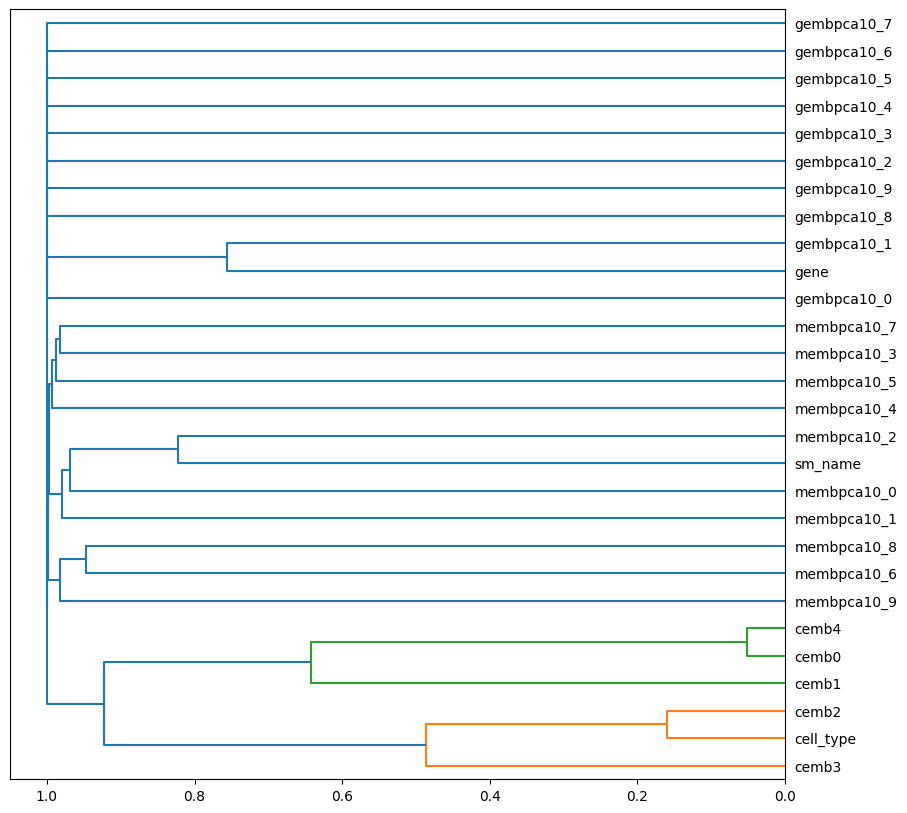

CPU times: user 21.5 s, sys: 684 ms, total: 22.2 s
Wall time: 21.9 s


In [17]:
%%time
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
correlation_matrix = xs.corr()
distances = 1 - np.abs(correlation_matrix)
np.fill_diagonal(distances.values, 0)
condensed_distances = squareform(distances)
linkage_matrix = hierarchy.linkage(condensed_distances, method='complete')
plt.figure(figsize=(10,10))
hierarchy.dendrogram(linkage_matrix, labels=xs.columns.tolist(), orientation='left')
plt.show()

## Train XGBoosted Forest

In [18]:
%%time
import xgboost as xgb
m = xgb.XGBRegressor(device='cuda', n_estimators=185, learning_rate=0.01, max_depth=20, min_child_weight=1, gamma=0, subsample=1, colsample_bytree=0.55, random_state=random_seed) # reg_lambda=10, alpha=10
m.fit(xs, y)
m_rmse(m, xs, y)

CPU times: user 14min 51s, sys: 14.7 s, total: 15min 5s
Wall time: 14min 45s


0.827387

## Inference and Submission

In [19]:
test_to = to.new(test_df_cmg)
test_to.process()
test_xs = test_to.xs
test_xs

,cell_type,sm_name,gene,cemb0,cemb1,cemb2,cemb3,cemb4,membpca10_0,membpca10_1,...,gembpca10_0,gembpca10_1,gembpca10_2,gembpca10_3,gembpca10_4,gembpca10_5,gembpca10_6,gembpca10_7,gembpca10_8,gembpca10_9
0,1,1,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,2.524892,-2.715401,...,-5.783766,-1.162082,-5.487963,0.597219,-2.413644,1.978386,-1.088238,-1.189460,-3.919738,1.454664
1,1,2,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,-1.219866,-0.877527,...,-5.783766,-1.162082,-5.487963,0.597219,-2.413644,1.978386,-1.088238,-1.189460,-3.919738,1.454664
2,1,3,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,0.025023,0.075566,...,-5.783766,-1.162082,-5.487963,0.597219,-2.413644,1.978386,-1.088238,-1.189460,-3.919738,1.454664
3,1,4,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,-1.469350,-1.851055,...,-5.783766,-1.162082,-5.487963,0.597219,-2.413644,1.978386,-1.088238,-1.189460,-3.919738,1.454664
4,1,5,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,0.551412,0.157118,...,-5.783766,-1.162082,-5.487963,0.597219,-2.413644,1.978386,-1.088238,-1.189460,-3.919738,1.454664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643800,2,142,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,-1.627801,2.048937,...,-7.473643,13.909636,3.644993,-3.208331,0.623480,1.706477,-1.906372,-1.625084,-2.556089,-1.414954
4643801,2,143,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,-0.976956,-0.495422,...,-7.473643,13.909636,3.644993,-3.208331,0.623480,1.706477,-1.906372,-1.625084,-2.556089,-1.414954
4643802,2,144,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,-1.961592,-0.395690,...,-7.473643,13.909636,3.644993,-3.208331,0.623480,1.706477,-1.906372,-1.625084,-2.556089,-1.414954
4643803,2,145,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,0.528172,2.419617,...,-7.473643,13.909636,3.644993,-3.208331,0.623480,1.706477,-1.906372,-1.625084,-2.556089,-1.414954


In [20]:
preds = tensor(m.predict(test_xs))
preds

tensor([0.1445, 0.0484, 0.3525,  ..., 0.0529, 0.0729, 0.0027])

In [21]:
preds.min(), preds.max()

(tensor(-39.3822), tensor(45.7507))

In the last step I reshape the predictions back into a 255 x 18211 tensor for submission:

In [22]:
to_submit = preds.view(18211, -1).t().numpy()
submit = pd.DataFrame(to_submit, columns=df_de_train.iloc[:,5:].columns)
submit.index.name = 'id'
submit

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.144532,0.097697,0.218878,0.422464,0.634642,0.418490,0.161516,0.143251,-0.050642,0.226666,...,-0.275419,0.042174,0.150236,0.180454,0.188498,0.168564,0.211868,0.206665,0.108887,0.102166
1,0.048379,0.083502,0.050673,0.032305,0.331244,0.379570,0.076715,0.090891,0.092799,0.068311,...,0.140867,0.055676,0.069065,0.127183,-0.000843,0.056842,0.079607,0.092260,0.191807,0.008099
2,0.352474,0.253288,-0.120226,0.069845,0.783086,1.575211,0.227260,0.278702,0.180755,0.017105,...,0.095922,-0.019841,0.097292,0.372933,0.288733,0.335558,0.211764,0.080145,-0.079149,-0.029725
3,0.058648,0.177821,0.128115,0.183578,0.199654,-0.004180,0.086318,0.134976,0.094547,0.172172,...,0.015959,0.071693,0.086283,0.071673,0.054778,0.070659,0.156871,0.157170,0.064725,0.073807
4,0.145470,0.112065,0.177095,0.216137,0.502080,0.532180,0.118584,0.163632,0.079262,0.193022,...,-0.059265,0.108609,0.106568,0.169740,0.169611,0.186792,0.165841,0.165005,0.127779,0.040362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,-0.044895,-0.006698,-0.078979,-0.113299,0.151060,-0.112445,0.086789,-0.015232,0.037589,0.194317,...,0.174391,-0.056133,-0.091285,-0.052333,-0.115649,-0.081528,0.019277,0.030966,-0.013222,0.111128
251,0.151207,0.187280,-0.132597,0.333636,0.522862,0.445981,0.073738,0.185577,0.017947,0.197529,...,0.203764,0.116074,-0.030715,0.166283,0.204016,0.178635,-0.032524,0.147701,-0.203280,-0.011037
252,-0.000433,0.104113,0.022420,0.015494,0.074020,-0.033199,0.062285,0.046922,0.091126,0.121988,...,0.074905,0.067168,0.117451,0.037119,0.021081,0.010854,0.108073,0.124953,0.083322,0.052904


In [23]:
submit.to_csv('submission.csv')